## Personality Predictor

This data was collected through the PersonalityCafe forum, as it provides a large selection of people and their MBTI personality type, as well as what they have written.

#### First Dataset:
- There are 8675 observations(rows)
- Each row has 1 individual’s personality type and their last 50 posts
- The personality type shown is selected by the user although the forum has a link to the test for those members who do not know what personality type they belong to.

#### Second Dataset:
- Shows the frequency of each personality type in the population
- Data source: "MBTI Manual" published by CPP

#### Goal:
Learn more about the correlations and differences between each personality type. Derive visuals and compare the personality types against each other.

#### Motivation:
I find psychology very interesting, I believe the more information people have, in this case about the personality type, the easier it will be for people to understand each other.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from collections import Counter

# Always make it pretty.
plt.style.use('seaborn')

### First Dataset came in a csv so we can simply load it into a pandas DataFrame

In [2]:
raw = pd.read_csv('data/mbti_1 2.csv')

In [3]:
raw.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [5]:
df2 = raw

### Second dataset also came in a csv. Again, we just load it into a pandas DataFrame

In [ ]:
population = pd.read_csv('TypePopulation.csv')
print(population.info())
population.head()

In [ ]:
#The Frequency column is a string, let's convert it into a float
population['Frequency'] = population['Frequency'].apply(lambda x: x.replace('%',''))

In [ ]:
population['Frequency'] = population['Frequency'].astype(float)
population.head()

In [ ]:
#cleaning this up so we can merge it with the dataset above
typecount = raw.groupby('type').agg({'type':'count'})
typecount['Type']=typecount.index
typecount.columns = ['Count','Type']
typecount.head()

In [ ]:
dfsummary = pd.merge(population, typecount, on='Type')
dfsummary.head()

## Plotting frequency of personality types in our dataset against that found in the population

In [ ]:
fig, ax1 = plt.subplots(figsize=(16,8))

color = 'c'
ax1.set_xlabel('Personality Type',size = 40)
ax1.set_ylabel('Number of Observations', color=color,size=40)
ax1.bar(dfsummary.Type,dfsummary.Count, color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.yticks(size=30)
plt.xticks(rotation=45,size=30)
ax2 = ax1.twinx()

color2 = 'orange'
ax2.set_ylabel('Frequency in Population', color=color2,size=40)
ax2.plot(dfsummary.Type, dfsummary.Frequency, color=color2)
ax2.tick_params(axis='y', labelcolor=color2)
plt.yticks(size=30)
plt.xticks(rotation=45,size=30)

fig.tight_layout()
fig.savefig('samplebarvpop.png')
plt.show()

### Now that we have an idea of the data let's get some information from our raw data
- Words per comment
- Links per comment
- Questions asked per comment

In [ ]:
raw['Words'] = raw['posts'].apply(lambda x: len(x.split())/50)
raw['Links'] = raw['posts'].apply(lambda x: x.count('http')/50)
raw['Questions'] = raw['posts'].apply(lambda x: x.count('?')/50)
raw.head()

In [ ]:
Ws = raw.groupby('type').agg({'Words':'mean'})
Qs = raw.groupby('type').agg({'Questions':'mean'})
Ls = raw.groupby('type').agg({'Links':'mean'})

In [ ]:
#merging our information to our summary DataFrame
dfsummary = merge_to_df(dfsummary,Qs,'Questions')
dfsummary = merge_to_df(dfsummary,Ls,'Links')
dfsummary = merge_to_df(dfsummary,Ws,'Words')

In [ ]:
dfsummary.head()

In [ ]:
#Convert our count column into a percentage
dfsummary['SampleFr'] = dfsummary['Count']/len(raw)*100
dfsummary.head()

### Now that we've got our sample % let's compare it to the population %

In [ ]:
fig, ax1 = plt.subplots(figsize=(16,10))

indices = range(len(dfsummary.Type))
width = np.min(np.diff(indices))/3.
ax1.set_xlabel('Personality Type',size = 40)
ax1.set_ylabel('Representation %',size=40)
ax1.bar(indices-width/2.,dfsummary.Frequency,width,color='darkviolet',label='Population')
ax1.bar(indices+width/2.,dfsummary.SampleFr,width,color='darkcyan',label='Sample')
ax1.set_xticklabels(dfsummary.Type.unique())
ax1.tick_params(axis='y')

plt.yticks(size=30)
plt.xticks(range(len(dfsummary.Type)), rotation=45,size=20)
ax1.legend(prop={'size': 20})
fig.tight_layout()
fig.savefig('samplevpop.png')

Looking at the data above, we can see that having “IN--” in the personality increases the chances of being active on a forum. Let's test this:

- Null hypothesis: "IN--" personalities have a higher likelyhood of being in this online forum

In [ ]:
#Adding another feature to our raw data
raw['IN'] = raw['type'].apply(lambda x: present(x,'IN'))

In [ ]:
dfsummary['IN'] = dfsummary['Type'].apply(lambda x: present(x,'IN'))

In [ ]:
#aggregate the information
IN = dfsummary.groupby('IN').agg({'Frequency':'sum','SampleFr':'sum','Count':'sum'})
IN['Frequency'] = IN['Frequency'].astype(int)
IN

We have a total of 8675 users, and 2978 of them are "IN--" we will test our hypothesis below, we will reject our hypothesis if we get a p-value greater than 0.05

$$ \text{# of "IN--"} \approx Binomial(8675, 0.11) $$

The central limit theorem tells us that a binomial with large $N$ is well approximated by a Normal distribution with the appropriate mean and varaince. Let's take a look at both plots belows.

$$ Binomial(8675, 0.11) \approx N(8675 \times 0.11, \sqrt{8675 \times 0.11 \times 0.89}) $$

In [ ]:
n = 8675
p = 0.11
binomial = stats.binom(n=n, p=p)
binomial_mean = p * n
binomial_var = n * p * (1-p)
normal_approx = stats.norm(binomial_mean, np.sqrt(binomial_var))
x = np.linspace(0, n, num =8000)

fig, axs = plt.subplots(2, figsize=(16, 6))
bar_sizes = [binomial.pmf(i) for i in range(n+1)]
bars = axs[0].bar(range(n+1), bar_sizes, color="darkviolet", align="center")
axs[0].plot(x, normal_approx.pdf(x), linewidth=3, alpha = 0.5)
axs[0].set_xlim(800, 1100)

bars = axs[1].bar(range(n+1), bar_sizes, color="grey", align="center")
axs[1].plot(x, normal_approx.pdf(x), linewidth=3, alpha = 0.5)
axs[1].set_xlim(800, 1100)

axs[0].set_title('# of "IN--" observations given the Null Hypothesis')
fig.savefig('distributions.png')

Let's continue with the Normal Distribution

The p-value for this is:

$$ P(\geq \text{ 2978 'IN--' observations} \mid \text{Null Hypothesis} ) $$

In [ ]:
p_value = 1 - normal_approx.cdf(2978)
print("p-value for the experiment: {:2.6f}".format(p_value))

In [ ]:
fig, ax = plt.subplots(1, figsize=(16, 3))

ax.plot(x, normal_approx.pdf(x), linewidth=3,color='red',alpha=0.5)
ax.set_xlim(850, 3200)
ax.fill_between(x, normal_approx.pdf(x), where=(x >= 2978), color="b",linewidth=3)
ax.arrow(2978,0.008,0.,-0.006,head_width=20, head_length=0.002, fc='black', ec='black')
ax.text(2900,0.009,'p-value', color='black', fontsize=18)
ax.set_title("p-value Reigon")
fig.savefig('pvalue.png')

Based on the data, we accept the Null Hypothesis

Let's take a look at all "IN--" personalities

In [ ]:
dfsummary[dfsummary.IN == 1]

Can we confidently say that INTPs ask more questions than the rest?

In [ ]:
fig, ax = plt.subplots(1, figsize=(16, 6))
INTP = raw['Questions'][(raw.IN == 1) & (raw.type == 'INTP')]
INTJ = raw['Questions'][(raw.IN == 1) & (raw.type == 'INTJ')]
INFJ = raw['Questions'][(raw.IN == 1) & (raw.type == 'INFJ')]
INFP = raw['Questions'][(raw.IN == 1) & (raw.type == 'INFP')]

ax.scatter(INTP, np.repeat(0, len(INTP)) + np.random.normal(0, 0.1, len(INTP)), s=45)
ax.scatter(INTJ, np.repeat(1, len(INTJ)) + np.random.normal(1, 0.1, len(INTJ)), s=45)
ax.scatter(INFJ, np.repeat(2, len(INFJ)) + np.random.normal(2, 0.1, len(INFJ)), s=45)
ax.scatter(INFP, np.repeat(3, len(INFP)) + np.random.normal(3, 0.1, len(INFP)), s=45)
ax.set_yticks([0,2,4,6])
ax.set_yticklabels(["INTP","INTJ","INFJ","INFP"])
ax.set_xlabel('Ratio of # of Questions to Posts',size = 30)
ax.set_ylabel('Personality Type',size=30)
plt.yticks(size=20)
plt.xticks(size=20)
fig.savefig('ratios.png')

In [ ]:
print(len(INFJ))
print(len(INTJ))
print(len(INTP))
print(len(INFP))

#### Take a Skeptical Stance, and Clearly State This Hypothesis.

> there is no difference in the average amount of questions asked between INTP and INTJ.

> there is no difference in the average amount of questions asked between INTP and INFJ.

> there is no difference in the average amount of questions asked between INTP and INFP.

Our question concerns population averages (is INTP's question average different than INTJ, INFJ and INFP).  Our measurements are sample averages, which, from the central limit theorem, we know are approximately normally distributed given the population average

$$ \text{Sample average of INTP's questions} \sim Normal \left( \mu_T, \sqrt{\frac{\sigma^2_T}{1304}} \right) $$
$$ \text{Sample average of INTJ's questions} \sim Normal \left( \mu_J, \sqrt{\frac{\sigma^2_J}{1091}} \right) $$
$$ \text{Sample average of INFJ's questions} \sim Normal \left( \mu_F, \sqrt{\frac{\sigma^2_F}{1470}} \right) $$
$$ \text{Sample average of INFP's questions} \sim Normal \left( \mu_P, \sqrt{\frac{\sigma^2_P}{1832}} \right) $$

If we are willing to assume that the Questions posted by INTP are independent from the other personalities, then we can compress the importnat information into one normal distribution

$$ \text{Difference in sample averages} \sim Normal \left( \mu_T - \mu_J, \sqrt{\frac{\sigma^2_T}{1304} + \frac{\sigma^2_J}{1091}} \right) $$
$$ \text{Difference in sample averages} \sim Normal \left( \mu_T - \mu_F, \sqrt{\frac{\sigma^2_T}{1304} + \frac{\sigma^2_F}{1470}} \right) $$
$$ \text{Difference in sample averages} \sim Normal \left( \mu_T - \mu_P, \sqrt{\frac{\sigma^2_T}{1304} + \frac{\sigma^2_P}{1832}} \right) $$

Under the assumption of the null hypothesis

$$ \text{Difference in sample averages} \sim Normal \left( 0, \sqrt{\frac{\sigma^2_T}{1304} + \frac{\sigma^2_J}{1091}} \right) $$
$$ \text{Difference in sample averages} \sim Normal \left( 0, \sqrt{\frac{\sigma^2_T}{1304} + \frac{\sigma^2_F}{1470}} \right) $$
$$ \text{Difference in sample averages} \sim Normal \left( 0, \sqrt{\frac{\sigma^2_T}{1304} + \frac{\sigma^2_P}{1832}} \right) $$

In cases where we have to independently estiamte the variance of a normal distribution from the same samples we are testing, this estimation of the variance contributes to uncertenty in our test.  This means that the Normal distribution is then **too precise** to use as a conservative estimate of the p-value.

### Welch's t-test

To recify the problem, we first convert to a sample statistic whose variance is expected to be $1$

$$ \frac{\text{Difference in sample averages}}{\sqrt{\frac{\sigma^2_T}{1304} + \frac{\sigma^2_J}{1091}}} $$
$$ \frac{\text{Difference in sample averages}}{\sqrt{\frac{\sigma^2_T}{1304} + \frac{\sigma^2_F}{1470}}} $$
$$ \frac{\text{Difference in sample averages}}{\sqrt{\frac{\sigma^2_T}{1304} + \frac{\sigma^2_P}{1832}}} $$

Now we still have a similar issue to the two sample test of population proportions, we do not know the population varainces in the denominator of the formula, so our only recourse is to substitute in the sample variances

In [ ]:
test_statistic1 = welch_test_statistic(INTP, INTJ)
print("Welch Test Statistic(v. INTJ): {:2.2f}".format(test_statistic1))
test_statistic2 = welch_test_statistic(INTP, INFJ)
print("Welch Test Statistic(v. INFJ): {:2.2f}".format(test_statistic2))
test_statistic3 = welch_test_statistic(INTP, INFP)
print("Welch Test Statistic(v. INFP): {:2.2f}".format(test_statistic3))

Unfortuantely, this changes the distribution of the test statistic.  Instead of using a normal distribution, we must now use a **Student's t-distribution**, which accounts for the extra uncertenty in estimating the two new parameters.

The t-distribution always has mean $0$ and varaince $1$, and has one parameter, the **degrees of freedom**.  Smaller degrees of freedom have heavyer tails, with the distribution beoming more normal as the degrees of freedom gets larger.

The resulting application to our situation results in [Welch's t-test](https://en.wikipedia.org/wiki/Welch's_t-test).

In [ ]:
welchdf1 = welch_satterhwaithe_df(INTP, INTJ)
print("Degrees of Freedom for Welch's Test: {:2.2f}".format(welchdf1))
welchdf2 = welch_satterhwaithe_df(INTP, INFJ)
print("Degrees of Freedom for Welch's Test: {:2.2f}".format(welchdf2))
welchdf3 = welch_satterhwaithe_df(INTP, INFP)
print("Degrees of Freedom for Welch's Test: {:2.2f}".format(welchdf3))

In [ ]:
x = np.linspace(-3, 3, num=250)

fig, ax = plt.subplots(3, figsize=(16, 9))
students1 = stats.t(welchdf1)
students2 = stats.t(welchdf2)
students3 = stats.t(welchdf3)
ax[0].plot(x, students1.pdf(x), linewidth=2, 
        label="Degree of Freedom: {:2.2f}".format(welchdf1))
ax[0].legend()
ax[0].set_title("Distribution of Welsh's Test Statistic Under the Null Hypothesis")
ax[1].plot(x, students2.pdf(x), linewidth=2, 
        label="Degree of Freedom: {:2.2f}".format(welchdf2))
ax[1].legend()
# ax[1].set_title("Distribution of Welsh's Test Statistic Under the Null Hypothesis")
ax[2].plot(x, students3.pdf(x), linewidth=2, 
        label="Degree of Freedom: {:2.2f}".format(welchdf3))
ax[2].legend()
fig.savefig('welchttest.png')

In [ ]:
x = np.linspace(-3, 3, num=250)

fig, ax = plt.subplots(3, figsize=(16, 9))
ax[0].plot(x, students1.pdf(x), linewidth=2, label="Degree of Freedom: {:2.2f}".format(welchdf1))
ax[0].fill_between(x, students1.pdf(x), where=(x >= -test_statistic1), color="red", alpha=0.25)
ax[0].fill_between(x, students1.pdf(x), where=(x <= test_statistic1), color="b", alpha=0.25)
ax[0].legend()
ax[0].set_title("p-value Region")

ax[1].plot(x, students1.pdf(x), linewidth=2, label="Degree of Freedom: {:2.2f}".format(welchdf2))
ax[1].fill_between(x, students2.pdf(x), where=(x >= -test_statistic2), color="red", alpha=0.25)
ax[1].fill_between(x, students2.pdf(x), where=(x <= test_statistic2), color="b", alpha=0.25)
ax[1].legend()
ax[1].set_title("p-value Region")

ax[2].plot(x, students1.pdf(x), linewidth=2, label="Degree of Freedom: {:2.2f}".format(welchdf3))
ax[2].fill_between(x, students3.pdf(x), where=(x >= -test_statistic3), color="red", alpha=0.25)
ax[2].fill_between(x, students3.pdf(x), where=(x <= test_statistic3), color="b", alpha=0.25)
ax[2].legend()
ax[2].set_title("p-value Region")
fig.savefig('pvalueregion.png')

Based on the result we can see that our datasets are not normally distributed, this is a good lesson for next time. Check the distribution before moving forward.

#### This means we must use: *Mann-Whitney Signed Rank Test*
Let us rephrase our null hypothesis to what we started with:

> $H_0$: INTPs ratio of questions to posts are equally likely to INTJs. i.e
  
  $$P(\text{INTPs questions/post} > \text{INTJs questions/post}) = 0.5$$

> $H_0$: INTPs ratio of questions to posts are equally likely to INFJs. i.e
  
  $$P(\text{INTPs questions/post} > \text{INFJs questions/post}) = 0.5$$

> $H_0$: INTPs ratio of questions to posts are equally likely to INFPs. i.e  
  
  $$P(\text{INTPs questions/post} > \text{INFPs questions/post}) = 0.5$$

We will set a rejection threshold of **0.01**

In [ ]:
res1 = stats.mannwhitneyu(INTP, INTJ, alternative="greater")
print("p-value for INTP > INTJ: {:2.10f}".format(res1.pvalue))
res2 = stats.mannwhitneyu(INTP, INFJ, alternative="greater")
print("p-value for INTP > INFJ: {:2.10f}".format(res2.pvalue))
res3 = stats.mannwhitneyu(INTP, INFP, alternative="greater")
print("p-value for INTP > INFP: {:2.10f}".format(res3.pvalue))

Based on our results:

> we fail to reject the first Null Hypothesis

> we reject the second Null Hypothesis

> we reject the third Null Hypothesis

#### Now let's go back to the data and see what we can derive
- Create a dictionary with all the observations of each Personality Type

In [ ]:
d={}
for ptype in raw['type'].unique():
        d[ptype]=raw.loc[raw['type'] == ptype,'posts':'posts']
        d[ptype].reset_index(drop=True, inplace=True)

#### Get the word frequency by personality type

In [ ]:
d2 = {}
for k,v in d.items():
    d2[k] = wordFrequency(v['posts'])
d2['INTP'].most_common(10)

#### After creating the dictionaries shown above, it made sense to create some word clouds.
- Getting the 30 most common words for all personality types

In [ ]:
common_words = wordFrequency(raw['posts'])
common_words.most_common(30)

In [ ]:
#creating a list of the 30 most common words
remove = []
for item in common_words.most_common(30):
    remove.append(' '+item[0]+' ')
remove

## Word Clouds

### Removing the 30 most common words in order to create wordclouds

In [ ]:
df2['posts'] = df2['posts'].apply(lambda x: clean_text(x))

#### Creating a word cloud for each personality type

In [ ]:
from scipy.misc import imread
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

fig, ax = plt.subplots(len(raw['type'].unique()), sharex=True, 
                       figsize=(15,10*len(df2['type'].unique())))

x = 0 #will serve as our plot index
for i in df2['type'].unique():
    df = df2[df2['type'] == i]
    wordcloud = WordCloud(background_color="white", max_words=100, colormap="tab10",
                          mask=transformed_head_mask).generate(df['posts'].to_string())
    ax[x].imshow(wordcloud, interpolation='bilinear')
    ax[x].set_title(i)
    ax[x].axis("off")
    wordcloud.to_file("{}.png".format(i))
    x+=1

### To create the mask we import the image as an array
- you need to import Image from PIL
- as seen below, we get an array that has 0s, we need to change this to 255 in order to use it with our word cloud
- need to check the shape so we can make a mask with the same shape

In [ ]:
head_mask = np.array(Image.open("head2.png"))
print(head_mask.shape)
print(head_mask[0])

### Let's use the function "transform_mask" to populate a new array
- once complete, verify the values have changed and the shape matches the original

In [ ]:
transformed_head_mask = np.ndarray((head_mask.shape[0],head_mask.shape[1], 
                                    head_mask.shape[2]),np.int32)
transformed_head_mask
for i in range(len(head_mask)):
    transformed_head_mask[i] = list(map(transform_mask, head_mask[i]))

In [ ]:
print(transformed_head_mask.shape)
print(transformed_head_mask[0])

### Now we go back to our dataset, verify that we have numerical data

In [ ]:
dfsummary.info()

In [ ]:
dfsummary.describe()

In [ ]:
pd.plotting.scatter_matrix(dfsummary,figsize=(16,16))

### We don't seem to have any obvious correlations between any of the independant features. 

## Functions
- Here are all the functions used throughout the notebook

In [ ]:
def wordFrequency(series):
    """
    Takes in the ['posts'] column and creates a dictionary of the words 
    found where the values are the frequncy of the word

    Parameters
    ----------
    series: a pandas.series

    Returns
    -------
    dictionary
    """
    count = Counter()
    for posts in series:
        pt = posts.split('|||')
        for sentance in pt:
            words = sentance.split(' ')
            for w in words:
                count[w] += 1
    return count

In [ ]:
def transform_mask(matrix):
    """
    Takes a 2D Matrix in and changes the 0 values to 255

    Parameters
    ----------
    Matrix: 2D matrix

    Returns
    -------
    list
    """
    l =[]
    for n in matrix:
        if n == 0:
            l.append(255)
        else:
            l.append(n)
    return l

In [ ]:
def merge_to_df(df,series,newcol):
    """
    Prepares a series to be merged with my summary df.
    Checks to see if the column exists, if it doesn't it returns
    the merged dataframe.
    
    Parameters
    ----------
    df: pandas.dataframe
    series: a pandas.series
    newcol: String
    

    Returns
    -------
    series
    """
    series['Type']=series.index
    series.coulmns = [newcol,'Type']
    if newcol in df.columns:
        return "Coloumn already in dataframe"
    else:
        return pd.merge(df, series, on='Type')

In [ ]:
def clean_text(string):
    """
    Removes all common text from the line and returns a cleaned version of the line
    String.
    
    Parameters
    ----------
    series: a pandas.series

    Returns
    -------
    String
    """
    for char in remove:
        string = string.replace(char,' ')
    return string

In [ ]:
def present(string,chars):
    """
    Checks if char is in string.
    
    Parameters
    ----------
    string: string

    Returns
    -------
    int: 1 for yes
         0 for no
    """
    if chars in string:
        return 1
    else:
        return 0

In [ ]:
def welch_test_statistic(sample_1, sample_2):
    """
    Takes two samples as a list or pandas.series and returns the Welch Test Statistic
    
    Parameters
    ----------
    sample_1: list or pandas.series
    sample_2: list or pandas.series

    Returns
    -------
    float: welch test statistic 
    """
    numerator = np.mean(sample_1) - np.mean(sample_2)
    denominator_sq = (np.var(sample_1) / len(sample_1)) + (np.var(sample_2) / len(sample_2))
    return numerator / np.sqrt(denominator_sq)

In [ ]:
def welch_satterhwaithe_df(sample_1, sample_2):
    ss1 = len(sample_1)
    ss2 = len(sample_2)
    df = (
        ((np.var(sample_1)/ss1 + np.var(sample_2)/ss2)**(2.0)) / 
        ((np.var(sample_1)/ss1)**(2.0)/(ss1 - 1) + (np.var(sample_2)/ss2)**(2.0)/(ss2 - 1))
    )
    return df

### Create a wordcloud for the Q&A portion of the presentation

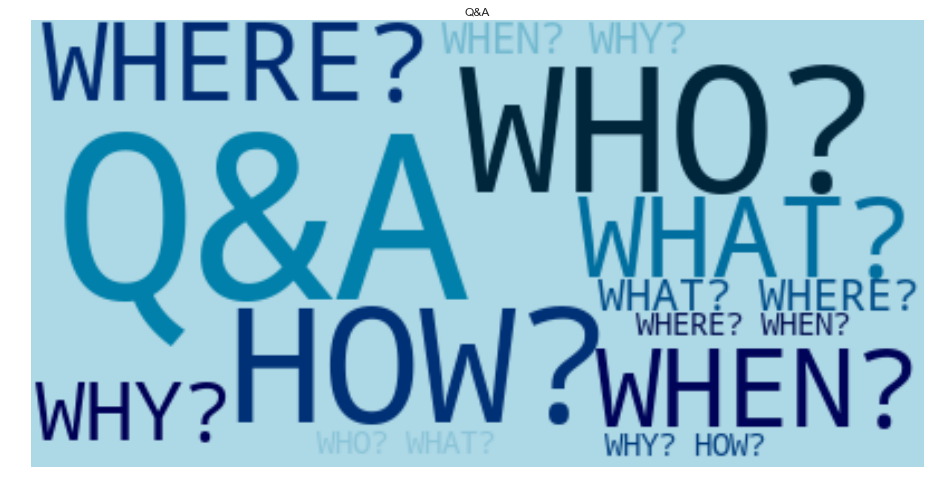

In [31]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
QA = ['Q&A','Q&A','Q&A','Q&A','Q&A','Q&A','Q&A','WHO?','WHO?', 'WHO?', 'WHO?',
      'WHAT?','WHAT?','WHAT? WHERE?','WHERE?','WHERE? WHEN?','WHEN?','WHEN? WHY?',
      'WHY?','WHY? HOW?','HOW?','HOW?','Q&A','Q&A','Q&A','Q&A','Q&A','WHO?', 'WHO?', 
      'WHO? WHAT?','WHAT?','WHAT? WHERE?','WHERE?','WHERE?','WHEN?','WHEN?','WHEN? WHY?',
      'WHY?','WHY?','HOW?','HOW?','HOW?']
wcd=Counter(QA)
fig, ax = plt.subplots(1, figsize=(16, 10))
wc = WordCloud(background_color="lightblue",colormap="ocean").generate_from_frequencies(wcd)
ax.imshow(wc, interpolation='bilinear')
ax.set_title('Q&A')
ax.axis("off")
wc.to_file("QA.png")

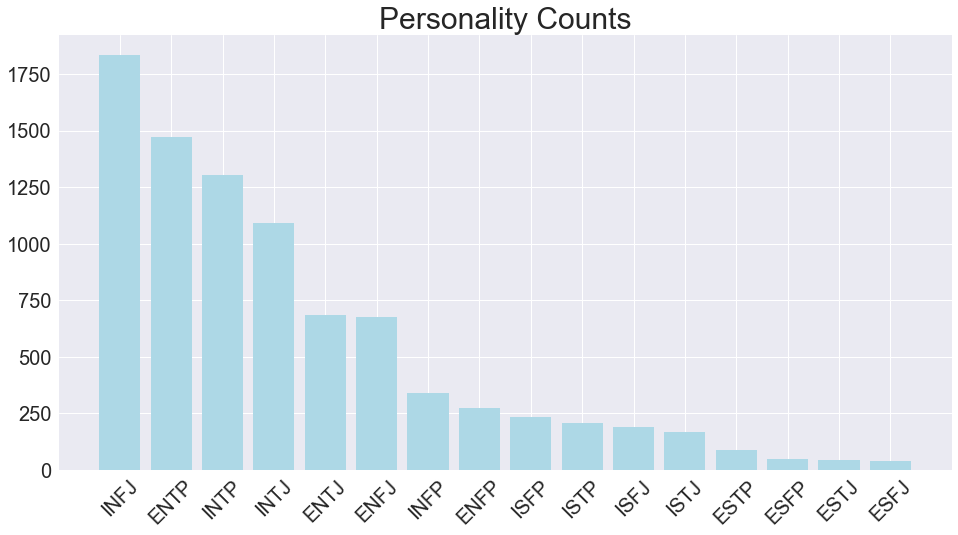

In [27]:
fig = plt.figure(figsize=(16,8))
plt.bar(df2.type.unique(),df2.type.value_counts(),color='lightblue')
plt.xticks(size=20,rotation=45)
plt.yticks(size=20)
plt.title('Personality Counts',size=30)
fig.savefig('img/unbalanced.png')